# LSTM RNN for stock prediction

### Necessary packages

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import numpy as np
import yfinance as yf 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
import torch.nn.functional as F

import helper

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/matei/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


### Getting stock data 

<AxesSubplot:xlabel='Date'>

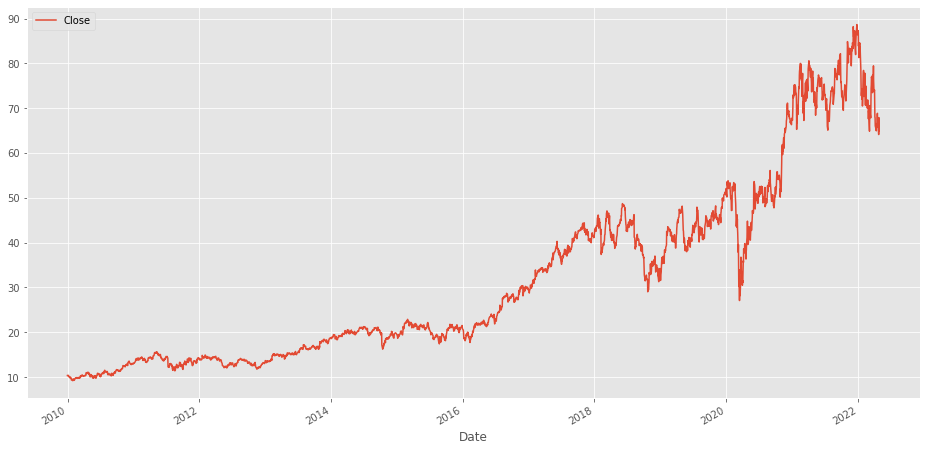

In [2]:
#Get stock information
stock = yf.Ticker('MCHP')

#Get the close day prices
mchp = stock.history(start='2010-01-01', end='2022-05-01', interval='1d')[[ 'Close']]

#Plot the colse price trend
mchp.plot(kind='line', figsize=(16, 8))

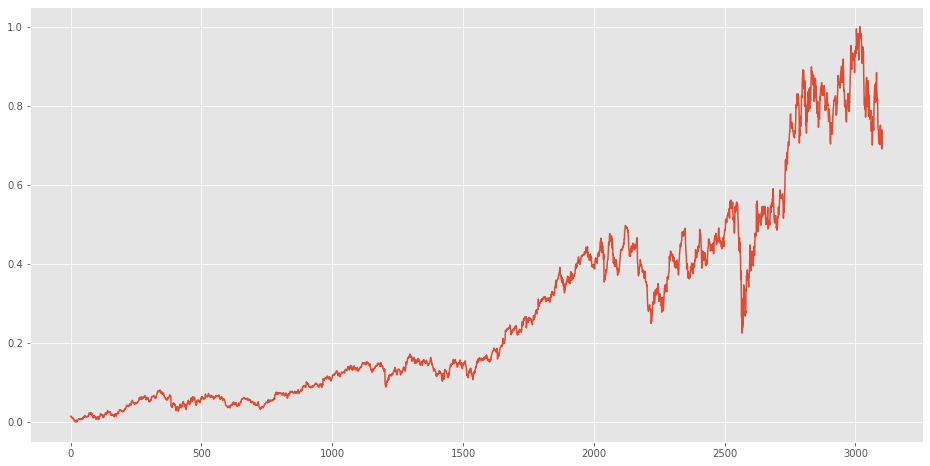

In [3]:
#to make the neural network training more stable we need to normlize our data. 
#Use a MinMaxScaler to bring the data in the range [0, 1]. 
#First, we instantiate a standard MinMax scaller
scaler = MinMaxScaler()

#Scale the close prices and save them as a numpy array
mchp_normalized = scaler.fit_transform(mchp[mchp.columns])

# Ploting the scaled trend (it should be between 0 and 1)
plt.figure(figsize=(16, 8))
plt.plot(mchp_normalized)


### Train/Test split & Batch creation 

First, split the data in mini-batches in proper sequences of lenght and then split the data into train and test sets in order to implement a train-validation loop. 

In [4]:
def make_batches(data, batch_size, seq_len):
    
    #Making 1-day rolling sequences of length window_size = 31
    window_size = seq_len + 1
    seq_data = np.array([data[i: i + window_size] for i in range(len(data) - window_size)])
    
    #Selecting features (nseq, seq_len, nfeatures) and targets (nseq, 1) for each sequence
    #Creating array x - 30 days of historic data (seq_len = 30) to predict y - following day data
    x = seq_data[:,:-1,:]
    y = seq_data[:,-1,:]

    #Computing the total number of batches
    n_batches = seq_data.shape[0] // batch_size
    
    #Keeping only enough points to make full batches for x, y
    x =  x[:(n_batches*batch_size), :, :]
    y =  y[:(n_batches*batch_size), :]
    print(x.shape)
    print(y.shape)
    #Reshapeing x, y in batch_size rows
    x = x.reshape((-1, batch_size, seq_len, x.shape[-1]))
    y = y.reshape((-1, batch_size, y.shape[-1]))

    return x, y

x, y = make_batches(mchp_normalized, 16, 30)
print(x.shape)
print(y.shape)

(3072, 30, 1)
(3072, 1)
(192, 16, 30, 1)
(192, 16, 1)


In [5]:
def train_test_split(x, y, test_size):
    
    #Setting the total number of batches either from x or y shapes
    nbatches = x.shape[0]
    
    #Computing training set size
    train_size = 1 -  test_size
    
    #Computing training split index
    train_idx = int(np.round(nbatches*train_size))

    #Computing x_train, y_train and transform to tensors of type "torch.Tensor"
    x_train = torch.from_numpy(x[:train_idx]).type(torch.Tensor)
    y_train = torch.from_numpy(y[:train_idx]).type(torch.Tensor)
    
    #Aggeregating x_train, y_train as a list
    trainset = [x_train, y_train]
    
     #Doing the same for x_test, y_test and testset list
    x_test = torch.from_numpy(x[train_idx:]).type(torch.Tensor)
    y_test = torch.from_numpy(y[train_idx:]).type(torch.Tensor)
    testset = [x_test, y_test]
    
    return trainset, testset

In [6]:
trainset, testset = train_test_split(x, y, 0.2)

### Implementation of LSTM Network 

In [7]:
# Implementing the LSTM network
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob = 0.5):
        super(Net, self).__init__()
        # Saving the internal attributes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Instantiating the lstm with dropout_prob and batch_first=True
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout_prob,batch_first=True)
        
        # Instantiating the linear readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        # Instantiating a dropout layer
        self.dropout = nn.Dropout(dropout_prob)
    
    def init_hidden(self, batch_size):
        # Creating initial zero long term (c0) and short term memory (h0) states
        # These states require gradient computation        
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        
        h0 = h0.to(device)
        c0 = c0.to(device)
        return h0, c0
        
    def forward(self, x):
        # Creating the initial memory states through init_hidden() and x.shape 
        h0, c0 = self.init_hidden(x.shape[0])
        
        # Computing the recurrent output and hidden states.
        # Note: We don't want to back-propagate the hidden state through the whole input history.
        #       That is, you must BPTT up to the initial state for the current batch.
        #       Thus, you must tell pytorch to treat the h0 and c0 as constants by using detach()
        #       thereby truncating gradient computation up to the sequence length 
        r_out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) 
        
        # We are interested only in the single price prediction after sequnce length steps,
        #       i.e. the type of the problem is seq-to-vector or many-to-one.
        #       So, We select only the last outputs in the sequence for every point in the batch.
        r_out = r_out[:, -1, :]
        
        # We apply the dropout layer
        out = self.dropout(r_out)
        
        # Readout the result through the linear layer
        out = self.fc(out) 
        
        return out

### Training LSTM network

Finally its time for train our network. Here are the definitions of hyper-parameters:

In [8]:
batch_size = 64 # the mini-batch size
seq_len = 14 # the sequence length -> setting forecast period
learning_rate = 0.0002 # training loop learning rate
test_size = 0.1 # the percentage of data to be used for testing

input_dim = 1 # the number of features in the input, here we have only one value
hidden_dim = 200 # the size of the hidden layer
num_layers = 2 # the number of reccurent layers
output_dim = 1 # the size of the output, here we have only one value -> the price
dropout_prob = 0.3 # dropout probability 

Finally, we implement the training/validation loop.

In [10]:
# Making the bacthes out of the normalized data
x, y = make_batches(mchp_normalized, batch_size, seq_len)

# Creating the train/test sets
trainset, testset = train_test_split(x, y, test_size)

# Instantiating the model and moving it to the appropiate device
model = Net(input_dim, hidden_dim, num_layers, output_dim, dropout_prob)
model = model.to(device)

# Instantiating the mean squared error loss
criterion = torch.nn.MSELoss(reduction='mean')

# Instantiating an Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

(3072, 14, 1)
(3072, 1)


In [11]:
epochs = 500
counter = 0

x_train = trainset[0]
y_train = trainset[1]

x_valid = testset[0]
y_valid = testset[1]

trainset_len = x_train.shape[0]*x_train.shape[1]
validset_len = x_valid.shape[0]*x_valid.shape[1]

valid_loss_min = np.Inf

for epoch in range(epochs):
    train_loss = 0
    for data, target in zip(x_train, y_train):
        counter += 1
        # Move the data and targets to the appropiate device
        data, target = data.to(device), target.to(device) 
    
        # Zero out the gradient
        optimizer.zero_grad()
        
        # Compute the output
        output = model(data)
        
        # Compute the loss
        loss = criterion(output, target)
        
        # Compute the gradient
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        train_loss += loss.item()*batch_size
    
    valid_loss = 0
    model.eval()
    # Implement the validation loop
    with torch.no_grad():
        for data, target in zip(x_valid, y_valid):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * batch_size
    model.train()

    train_loss = train_loss / trainset_len
    valid_loss = valid_loss / validset_len
    
    if valid_loss <= valid_loss_min:
            helper.save_model(model, 'chepoint.pth')
            valid_loss_min = valid_loss
            
    print("Epoch: {}/{}.. ".format(epoch + 1, epochs),
          "Step: {}...".format(counter),
          "Training Loss: {:.5f}.. ".format(train_loss),
          "Validation Loss: {:.5f}.. ".format(valid_loss))

Epoch: 1/500..  Step: 43... Training Loss: 0.00499..  Validation Loss: 0.10454.. 
Epoch: 2/500..  Step: 86... Training Loss: 0.06183..  Validation Loss: 0.41240.. 
Epoch: 3/500..  Step: 129... Training Loss: 0.02631..  Validation Loss: 0.26717.. 
Epoch: 4/500..  Step: 172... Training Loss: 0.03271..  Validation Loss: 0.23147.. 
Epoch: 5/500..  Step: 215... Training Loss: 0.02454..  Validation Loss: 0.06372.. 
Epoch: 6/500..  Step: 258... Training Loss: 0.01608..  Validation Loss: 0.01683.. 
Epoch: 7/500..  Step: 301... Training Loss: 0.00767..  Validation Loss: 0.01195.. 
Epoch: 8/500..  Step: 344... Training Loss: 0.00537..  Validation Loss: 0.00495.. 
Epoch: 9/500..  Step: 387... Training Loss: 0.00117..  Validation Loss: 0.00301.. 
Epoch: 10/500..  Step: 430... Training Loss: 0.00146..  Validation Loss: 0.00216.. 
Epoch: 11/500..  Step: 473... Training Loss: 0.00133..  Validation Loss: 0.00191.. 
Epoch: 12/500..  Step: 516... Training Loss: 0.00116..  Validation Loss: 0.00185.. 
Epo

Epoch: 98/500..  Step: 4214... Training Loss: 0.00051..  Validation Loss: 0.00154.. 
Epoch: 99/500..  Step: 4257... Training Loss: 0.00048..  Validation Loss: 0.00123.. 
Epoch: 100/500..  Step: 4300... Training Loss: 0.00046..  Validation Loss: 0.00104.. 
Epoch: 101/500..  Step: 4343... Training Loss: 0.00055..  Validation Loss: 0.00218.. 
Epoch: 102/500..  Step: 4386... Training Loss: 0.00053..  Validation Loss: 0.00156.. 
Epoch: 103/500..  Step: 4429... Training Loss: 0.00077..  Validation Loss: 0.00226.. 
Epoch: 104/500..  Step: 4472... Training Loss: 0.00113..  Validation Loss: 0.00959.. 
Epoch: 105/500..  Step: 4515... Training Loss: 0.00093..  Validation Loss: 0.00100.. 
Epoch: 106/500..  Step: 4558... Training Loss: 0.00050..  Validation Loss: 0.00122.. 
Epoch: 107/500..  Step: 4601... Training Loss: 0.00045..  Validation Loss: 0.00127.. 
Epoch: 108/500..  Step: 4644... Training Loss: 0.00054..  Validation Loss: 0.00180.. 
Epoch: 109/500..  Step: 4687... Training Loss: 0.00055..

Epoch: 194/500..  Step: 8342... Training Loss: 0.00040..  Validation Loss: 0.00152.. 
Epoch: 195/500..  Step: 8385... Training Loss: 0.00046..  Validation Loss: 0.00120.. 
Epoch: 196/500..  Step: 8428... Training Loss: 0.00061..  Validation Loss: 0.00560.. 
Epoch: 197/500..  Step: 8471... Training Loss: 0.00058..  Validation Loss: 0.00114.. 
Epoch: 198/500..  Step: 8514... Training Loss: 0.00047..  Validation Loss: 0.00298.. 
Epoch: 199/500..  Step: 8557... Training Loss: 0.00047..  Validation Loss: 0.00091.. 
Epoch: 200/500..  Step: 8600... Training Loss: 0.00037..  Validation Loss: 0.00165.. 
Epoch: 201/500..  Step: 8643... Training Loss: 0.00040..  Validation Loss: 0.00090.. 
Epoch: 202/500..  Step: 8686... Training Loss: 0.00046..  Validation Loss: 0.00292.. 
Epoch: 203/500..  Step: 8729... Training Loss: 0.00055..  Validation Loss: 0.00160.. 
Epoch: 204/500..  Step: 8772... Training Loss: 0.00046..  Validation Loss: 0.00218.. 
Epoch: 205/500..  Step: 8815... Training Loss: 0.00051

Epoch: 289/500..  Step: 12427... Training Loss: 0.00063..  Validation Loss: 0.00101.. 
Epoch: 290/500..  Step: 12470... Training Loss: 0.00034..  Validation Loss: 0.00236.. 
Epoch: 291/500..  Step: 12513... Training Loss: 0.00033..  Validation Loss: 0.00078.. 
Epoch: 292/500..  Step: 12556... Training Loss: 0.00031..  Validation Loss: 0.00086.. 
Epoch: 293/500..  Step: 12599... Training Loss: 0.00026..  Validation Loss: 0.00063.. 
Epoch: 294/500..  Step: 12642... Training Loss: 0.00029..  Validation Loss: 0.00059.. 
Epoch: 295/500..  Step: 12685... Training Loss: 0.00030..  Validation Loss: 0.00089.. 
Epoch: 296/500..  Step: 12728... Training Loss: 0.00032..  Validation Loss: 0.00135.. 
Epoch: 297/500..  Step: 12771... Training Loss: 0.00032..  Validation Loss: 0.00074.. 
Epoch: 298/500..  Step: 12814... Training Loss: 0.00044..  Validation Loss: 0.00288.. 
Epoch: 299/500..  Step: 12857... Training Loss: 0.00047..  Validation Loss: 0.00136.. 
Epoch: 300/500..  Step: 12900... Training L

Epoch: 384/500..  Step: 16512... Training Loss: 0.00022..  Validation Loss: 0.00065.. 
Epoch: 385/500..  Step: 16555... Training Loss: 0.00022..  Validation Loss: 0.00056.. 
Epoch: 386/500..  Step: 16598... Training Loss: 0.00023..  Validation Loss: 0.00059.. 
Epoch: 387/500..  Step: 16641... Training Loss: 0.00021..  Validation Loss: 0.00064.. 
Epoch: 388/500..  Step: 16684... Training Loss: 0.00021..  Validation Loss: 0.00059.. 
Epoch: 389/500..  Step: 16727... Training Loss: 0.00028..  Validation Loss: 0.00076.. 
Epoch: 390/500..  Step: 16770... Training Loss: 0.00024..  Validation Loss: 0.00078.. 
Epoch: 391/500..  Step: 16813... Training Loss: 0.00025..  Validation Loss: 0.00074.. 
Epoch: 392/500..  Step: 16856... Training Loss: 0.00034..  Validation Loss: 0.00139.. 
Epoch: 393/500..  Step: 16899... Training Loss: 0.00047..  Validation Loss: 0.00223.. 
Epoch: 394/500..  Step: 16942... Training Loss: 0.00089..  Validation Loss: 0.00736.. 
Epoch: 395/500..  Step: 16985... Training L

Epoch: 479/500..  Step: 20597... Training Loss: 0.00025..  Validation Loss: 0.00071.. 
Epoch: 480/500..  Step: 20640... Training Loss: 0.00023..  Validation Loss: 0.00068.. 
Epoch: 481/500..  Step: 20683... Training Loss: 0.00023..  Validation Loss: 0.00090.. 
Epoch: 482/500..  Step: 20726... Training Loss: 0.00024..  Validation Loss: 0.00060.. 
Epoch: 483/500..  Step: 20769... Training Loss: 0.00025..  Validation Loss: 0.00092.. 
Epoch: 484/500..  Step: 20812... Training Loss: 0.00033..  Validation Loss: 0.00106.. 
Epoch: 485/500..  Step: 20855... Training Loss: 0.00053..  Validation Loss: 0.00450.. 
Epoch: 486/500..  Step: 20898... Training Loss: 0.00038..  Validation Loss: 0.00055.. 
Epoch: 487/500..  Step: 20941... Training Loss: 0.00020..  Validation Loss: 0.00109.. 
Epoch: 488/500..  Step: 20984... Training Loss: 0.00023..  Validation Loss: 0.00054.. 
Epoch: 489/500..  Step: 21027... Training Loss: 0.00021..  Validation Loss: 0.00070.. 
Epoch: 490/500..  Step: 21070... Training L

In [12]:
# Getting targets and the predictions for the entire dataset (trainset + testset)
model = helper.load_model(model,'chepoint.pth')
model.to(device)
x_all_seq = torch.from_numpy(x.reshape((-1, seq_len, 1)),).type(torch.Tensor).to(device)
y_all_targets = y.reshape((-1, 1))
y_all_pred = model(x_all_seq).cpu()
y_all_pred = y_all_pred.detach().numpy()

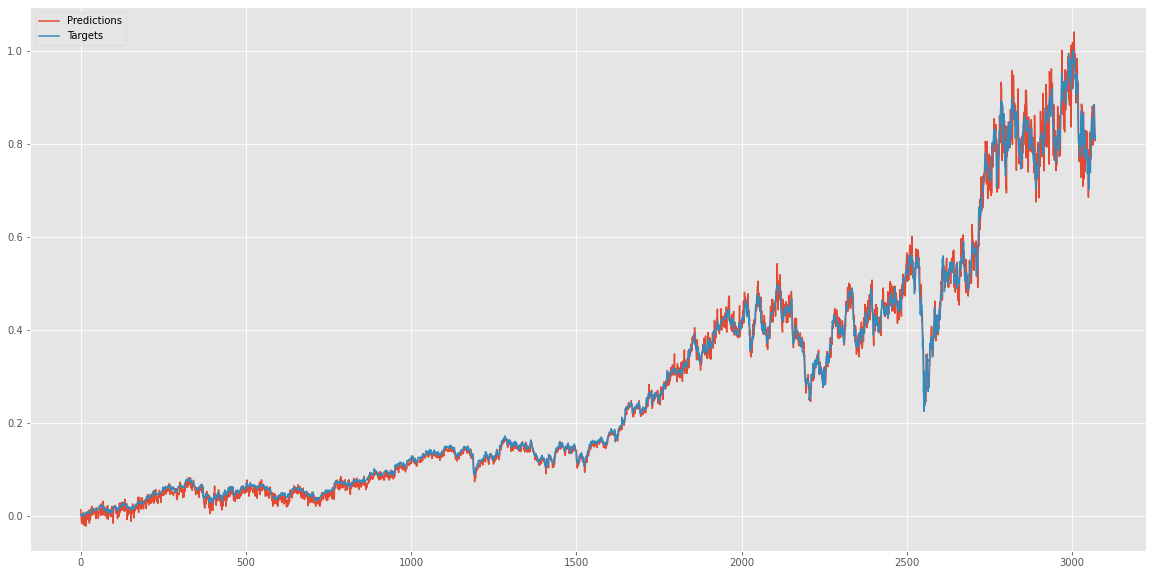

In [13]:
# Plotting the target and the predicted trends
plt.figure(figsize=(20, 10))
plt.plot(y_all_pred, label="Predictions")
plt.plot(y_all_targets, label="Targets")
plt.legend()
plt.show()

In [22]:
print("Average prediction: ",np.average(y_all_pred))
print("Average target:     ",np.average(y_all_targets))

Average prediction:  0.27738276
Average target:      0.28052303673066137


In [20]:
#The results seem to be pretty close to the actual target.
#But the model is too simple to make real world investments based on it.
#So, there must be some reasons for which the model would not work well in a real setting.